In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv('/Users/shovitraj/Github/Python/MagNet_data/hourly_df.csv',
               index_col=['timedelta','period'])
df.head(2)

,,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,temperature,dst,smoothed_ssn,gse_x_ace,gse_y_ace,gse_z_ace,by_gse_std,bz_gse_std,bt_std,density_std,speed_std
timedelta,period,,,,,,,,,,,,,,,,,,,
0 days 00:00:00,train_a,-6.149500,1.6455,0.844667,7.103667,165.420333,7.140000,1.174167,355.278250,68880.341667,-7,65.400000,1.522377e+06,143704.600000,149496.700000,1.224754,0.580028,1.607043,0.479647,15.025364
0 days 01:00:00,train_a,-6.693833,0.7665,1.265167,10.183333,174.267833,7.284833,0.815917,330.080583,52203.225000,-10,65.421154,1.522503e+06,143388.108333,149560.758333,0.907098,0.731278,0.325293,0.698365,17.203299


In [3]:
normalized_df=(df-df.min())/(df.max()-df.min())


In [4]:
normalized_df.rename(columns={'dst':'t0'},inplace=True)
normalized_df['t1']=normalized_df.groupby("period")['t0'].shift(-1)
normalized_df[['t1']]=normalized_df[['t1']].interpolate(method='linear', limit_direction='forward', axis=0)

In [5]:
normalized_df.isnull().sum().sum()

0

In [6]:
len(normalized_df)

139872

Train Test Split

In [7]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = data.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val

train, test, val = get_train_test_val(normalized_df, test_per_period=5000, val_per_period=5000)

In [8]:
print(len(train),len(test),len(val))

124872 15000 15000


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras import preprocessing

In [10]:
XCOLS=list(normalized_df.columns)
XCOLS.remove('t0')
XCOLS.remove('t1')
YCOLS=['t0','t1']

In [11]:

data_config = {
    "timesteps": 32,
    "batch_size": 64,
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset


train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 1950
Number of val batches: 234


In [12]:
# define our model
model_config = {"n_epochs": 50, "n_neurons": 64, "dropout": 0.4, "stateful": False}

model = Sequential()
model.add(
    LSTM(
        model_config["n_neurons"],
        # usually set to (`batch_size`, `sequence_length`, `n_features`)
        # setting the batch size to None allows for variable length batches
        batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
        stateful=model_config["stateful"],
        dropout=model_config["dropout"],
    )
)
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(len(YCOLS)))
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                21248     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 27,554
Trainable params: 27,554
Non-trainable params: 0
_________________________________________________________________


In [13]:
import time
start=time.time()
history = model.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=1,
    shuffle=False,
    validation_data=val_ds,
)
print('Time Taken:', time.time()-start)

Epoch 1/50
1950/1950 [==============================] - 31s 15ms/step - loss: 0.0132 - val_loss: 0.0017
Epoch 2/50
1950/1950 [==============================] - 31s 16ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 3/50
1950/1950 [==============================] - 30s 15ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 4/50
1950/1950 [==============================] - 30s 15ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 5/50
1950/1950 [==============================] - 29s 15ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 6/50
1950/1950 [==============================] - 33s 17ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/50
1950/1950 [==============================] - 29s 15ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 8/50
1950/1950 [==============================] - 29s 15ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/50
1950/1950 [==============================] - 29s 15ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 10/50
1950/1950 [==============================] - 28s 14m

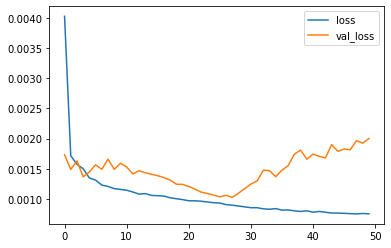

In [14]:
for name, values in history.history.items():
    plt.plot(values,label=name)
    plt.legend()

In [15]:
start=time.time()
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])
print('Time Taken:', time.time()-start)
mse = model.evaluate(test_ds)
print(f"Test RMSE: {mse**.5:.3f}")

Time Taken: 0.12116003036499023
234/234 [==============================] - 2s 7ms/step - loss: 0.0020
Test RMSE: 0.045


In [16]:
# define our model
model_config = {"n_epochs": 50, "n_neurons": 128, "dropout": 0.4, "stateful": False}

model = Sequential()
model.add(
    LSTM(
        model_config["n_neurons"],
        # usually set to (`batch_size`, `sequence_length`, `n_features`)
        # setting the batch size to None allows for variable length batches
        batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
        stateful=model_config["stateful"],
        dropout=model_config["dropout"],
    )
)
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(len(YCOLS)))
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               75264     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 85,666
Trainable params: 85,666
Non-trainable params: 0
_________________________________________________________________


In [17]:
import time
start=time.time()
history = model.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=1,
    shuffle=False,
    validation_data=val_ds,
)
print('Time Taken:', time.time()-start)

Epoch 1/50
1950/1950 [==============================] - 50s 25ms/step - loss: 0.0079 - val_loss: 0.0019
Epoch 2/50
1950/1950 [==============================] - 49s 25ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 3/50
1950/1950 [==============================] - 47s 24ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 4/50
1950/1950 [==============================] - 44s 23ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 5/50
1950/1950 [==============================] - 46s 24ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 6/50
1950/1950 [==============================] - 48s 25ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 7/50
1950/1950 [==============================] - 45s 23ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 8/50
1950/1950 [==============================] - 48s 25ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/50
1950/1950 [==============================] - 57s 29ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 10/50
1950/1950 [==============================] - 50s 26m

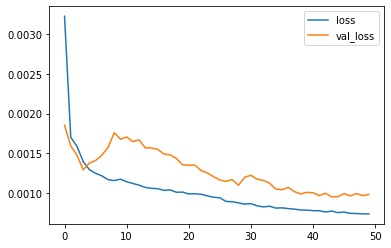

In [18]:
for name, values in history.history.items():
    plt.plot(values,label=name)
    plt.legend()

In [19]:
start=time.time()
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])
print('Time Taken:', time.time()-start)
mse = model.evaluate(test_ds)
print(f"Test RMSE: {mse**.5:.3f}")

Time Taken: 0.15487098693847656
234/234 [==============================] - 3s 10ms/step - loss: 9.7761e-04
Test RMSE: 0.031


In [21]:
import json
import pickle

model.save("model")

with open("scaler.pck", "wb") as f:
    pickle.dump(scaler, f)

data_config["solar_wind_subset"] = SOLAR_WIND_FEATURES
print(data_config)
with open("config.json", "w") as f:
    json.dump(data_config, f)

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


NameError: name 'scaler' is not defined